<a href="https://colab.research.google.com/github/KarinaRmzG/Neuronal-Networks/blob/main/EVC_P2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Aprendizaje por transferencia**

El aprendizaje por transferencia (transfer learning) utiliza el conocimiento adquirido en una tarea para resolver una tarea relativamente similar. En el caso del aprendizaje profundo el conocimiento está representado en los pesos de una red neuronal, estos pesos se ajustan en una primera tarea y se reutilizan para resolver otra. En este caso se utiliza aprendizaje por transferencia para realizar la clasificación de imágenes de rayos x del pecho en las categorías de Neumonía o no-neumonía.

El notebook a continuación presenta la implementación del aprendizaje utilizando la red entrenada VGG en la clasificación de las imágenes contenidas en el NIH-chest ray dataset.

In [ ]:
# Paquetes requeridos

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
from itertools import chain

import tensorflow as tf
from tensorflow import keras
import sklearn as sk
import sklearn.model_selection as skl
from sklearn.metrics import f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

In [ ]:
import sys

python_version = sys.version
print("Versión de Python:", python_version)
print("Versión de TensorFlow:", tf.__version__)
#print("Versión de Keras (integrada en TensorFlow):", tf.keras.__version__)
print("Versión de pandas:", pd.__version__)
print("Versión de scikit-learn (sklearn):", sk.__version__)
# Comprueba si hay una GPU disponible
if tf.test.is_gpu_available():
    print("GPU está disponible")
else:
    print("No se ha encontrado una GPU")

Versión de Python: 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
Versión de TensorFlow: 2.14.0
Versión de pandas: 1.5.3
Versión de scikit-learn (sklearn): 1.2.2
GPU está disponible


In [ ]:
# Experiment name
model_name = 'VGG16'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Step 1: Data preparation

In [ ]:
# Data paths
data_dir = '/content/drive/MyDrive/Brain_Stroke_CT-SCAN_image'
train_dir = os.path.join(data_dir, 'Train')
test_dir = os.path.join(data_dir, 'Test')
validation_dir = os.path.join(data_dir, 'Validation')

In [ ]:
#Hiperparámetros
batch_size = 200

# Parametros
IMG_SIZE = (224, 224)

In [ ]:
# Data Generator for training includes random modifications to the images
my_idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True,
                              vertical_flip = False,
                              height_shift_range= 0.1,
                              width_shift_range=0.1,
                              rotation_range=20,
                              shear_range = 0.1,
                              zoom_range=0.1)

# Data generator for validation does not include random modifications
my_idg_no_augmentation = ImageDataGenerator(rescale=1. / 255.0)

In [ ]:
train_gen = my_idg.flow_from_directory(
    directory='/content/drive/MyDrive/Brain_Stroke_CT-SCAN_image/Train',
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode='binary'
)

test_gen = my_idg_no_augmentation.flow_from_directory(
    directory='/content/drive/MyDrive/Brain_Stroke_CT-SCAN_image/Test',
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode='binary'
)


Found 1843 images belonging to 2 classes.
Found 437 images belonging to 2 classes.


In [ ]:
# Data augmentation and preprocessing
"""train_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='binary'
)"""

Found 1843 images belonging to 2 classes.
Found 235 images belonging to 2 classes.


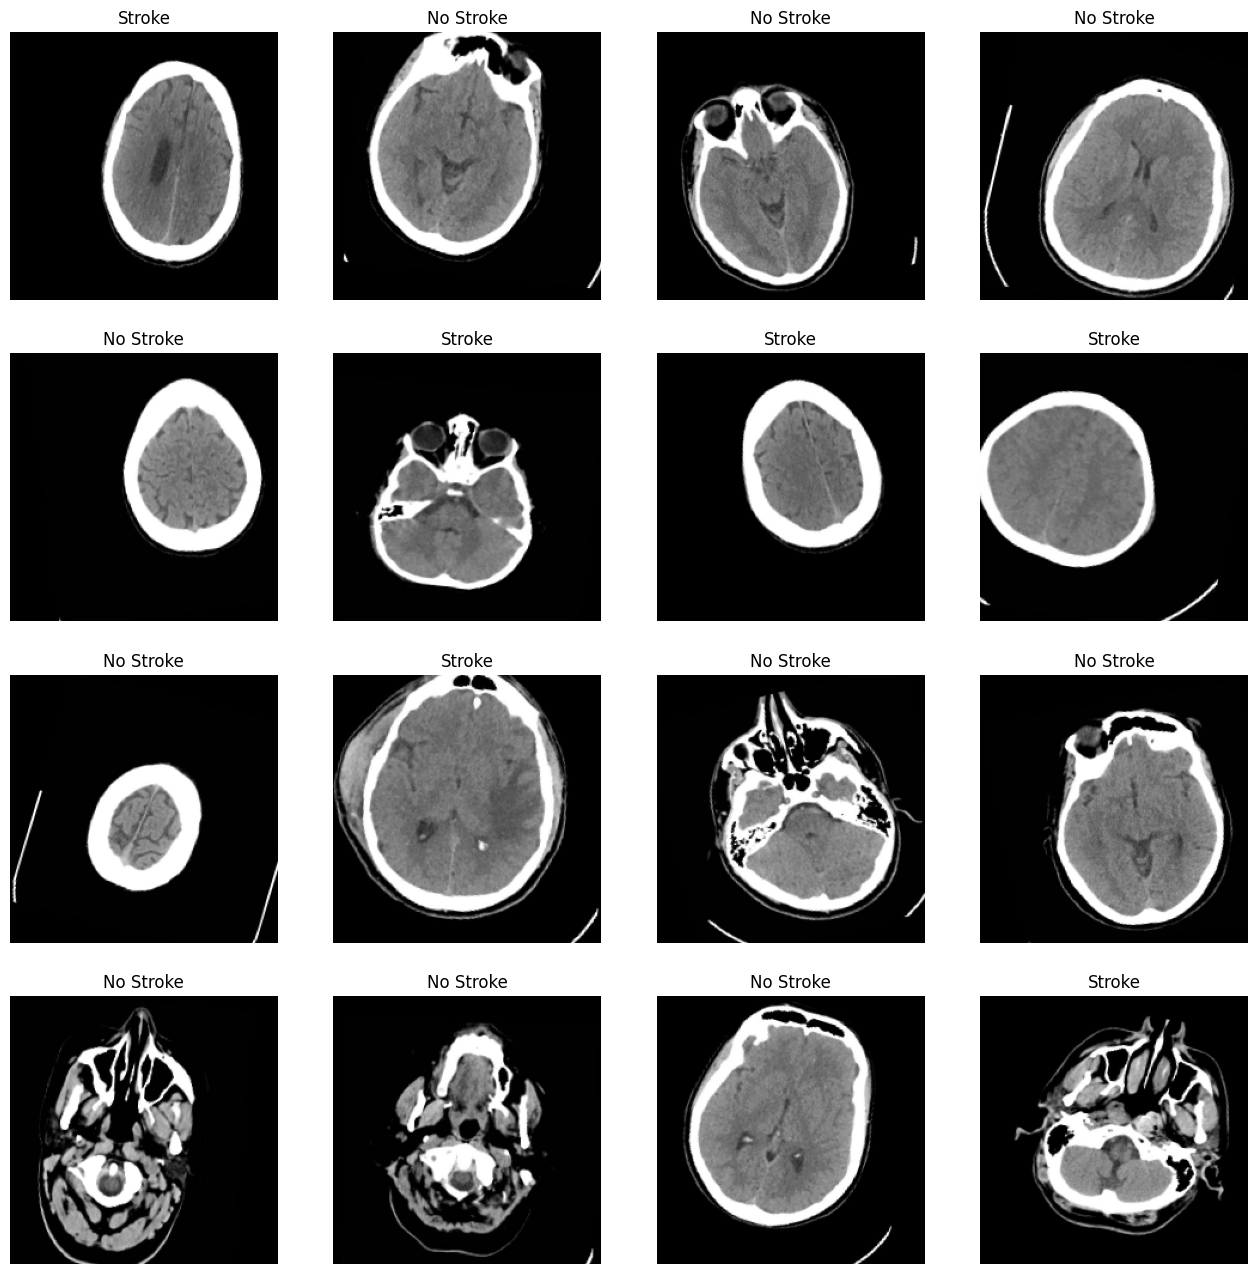

In [ ]:
import matplotlib.pyplot as plt

# Obtén un lote de imágenes y etiquetas del generador de entrenamiento
images, labels = train_gen.next()

# Crear una figura para visualizar imágenes generadas
fig, m_axs = plt.subplots(4, 4, figsize=(16, 16))

# Iterar a través de las imágenes y etiquetas generadas por el generador de datos de entrenamiento
for (c_x, c_y, c_ax) in zip(images, labels, m_axs.flatten()):
    # Mostrar la imagen utilizando el mapa de colores 'bone'
    c_ax.imshow(c_x)

    # Establecer el título de la imagen según la etiqueta '1' o '0' (o las clases específicas que tengas)
    if c_y == 1:
        c_ax.set_title('Stroke')
    else:
        c_ax.set_title('No Stroke')

    # Desactivar los ejes para una presentación más limpia
    c_ax.axis('off')

plt.show()

In [ ]:
## Pare realizar la validación del entrenamiento utilizaremos un lote de tamaño batch-size
valX, valY = test_gen.next()
print(valY)

[1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1.
 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1.
 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.
 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0.]


# **Construcción del modelo**

Utilizaremos la arquitectura de VGG16 preentrenada con el conjunto de datos de ImageNet.

En verde se muestra el modelo reutilizado, en azul los componentes congelados y en naranja los componentes a entrenar.

Los siguientes pasos son:
* Instanciar el modelo
* Descargar y asignar los pesos
* Eliminar la capa completamente conectada y mantener las capas convolucionales con sus respectivos pesos
* Agregar cuatro capas completamente conectadas con pesos aleatorios

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

# Cargar el modelo VGG16 preentrenado con pesos de ImageNet
model = VGG16(weights='imagenet', include_top=True)

# Imprimir la arquitectura del modelo
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# Obtiene la capa dado su nombre o índice
transfer_layer = model.get_layer('block5_pool')

# Agrupa las capas en un solo objeto entrenable.
# "Model groups layers into an object with training and inference features."
modelo_reutilizado = Model(inputs=model.input,
                   outputs=transfer_layer.output)

# Congelar los pesos hasta la penúltima capa convolucional
for layer in modelo_reutilizado.layers[0:17]:
    layer.trainable = False

# Imprime el nombre de cada capa y si sus pesos son entrenables o no
for layer in modelo_reutilizado.layers:
    print(layer.name, layer.trainable)


input_3 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 True
block5_pool True


In [ ]:
# Crea un modelo Sequential (modelo secuencial) personalizado
modelo_personalizado = Sequential()

# Agrega la parte convolucional del modelo VGG16 previamente definido
modelo_personalizado.add(modelo_reutilizado)

# Aplana la salida del modelo VGG16 porque proviene de una capa convolucional
modelo_personalizado.add(Flatten())

# Agrega una capa de dropout que puede prevenir el sobreajuste y mejorar la generalización a datos no vistos (por ejemplo, el conjunto de pruebas)
modelo_personalizado.add(Dropout(0.5))

# Agrega una capa densa (totalmente conectada) que combina las características que el modelo VGG16 ha reconocido en la imagen
modelo_personalizado.add(Dense(1024, activation='relu'))

# Agrega otra capa de dropout para prevenir el sobreajuste
modelo_personalizado.add(Dropout(0.5))

# Agrega otra capa densa (totalmente conectada)
modelo_personalizado.add(Dense(512, activation='relu'))

# Agrega otra capa de dropout para prevenir el sobreajuste
modelo_personalizado.add(Dropout(0.5))

# Agrega otra capa densa (totalmente conectada)
modelo_personalizado.add(Dense(256, activation='relu'))

# Agrega una última capa densa (totalmente conectada)
# Cambia la función de activación a sigmoid para que la salida de la última capa esté en el rango de [0,1]
modelo_personalizado.add(Dense(1, activation='sigmoid'))


# **Establecer optimizador**

* Hay diversos optimizadores, Adam selecciona el valor del learning rate de forma automática conforme avanzan las épocas.
* La métrica de pérdida es entropía cruzada binaria.
* Compilar modelo

In [ ]:
# Establece nuestro optimizador, función de pérdida y tasa de aprendizaje
optimizer = Adam(lr=1e-4)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']

In [ ]:
# Compila el modelo personalizado con el optimizador, función de pérdida y métricas especificadas
modelo_personalizado.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
# Verifica que el modelo esté entrenando utilizando el método fit_generator

# train_gen: El generador de datos de entrenamiento que proporciona muestras y etiquetas de entrenamiento.
# validation_data: Los datos de validación en forma de tupla (valX, valY), que incluye las muestras de validación y sus etiquetas.
# epochs: Número de épocas de entrenamiento, en este caso, se establece en 1 para una sola época de entrenamiento.
modelo_personalizado.fit(train_gen,
                                  validation_data=(valX, valY),
                                  epochs=1)

10/10 [==============================] - 122s 4s/step - loss: 0.6962 - binary_accuracy: 0.5648 - val_loss: 0.6225 - val_binary_accuracy: 0.7450


In [ ]:
## Funciones callbacks para guardar los mejores pesos durante el entrenamiento

# Define el nombre del archivo para guardar los mejores pesos del modelo
weight_path="{}_my_model.best.hdf5".format('xray_class')
#weight_path = "xray_class_my_model.best.hdf5"

# Configura la función de callback ModelCheckpoint
# para guardar los pesos cuando se logra la mejora en la métrica de validación
checkpoint = ModelCheckpoint(weight_path,
                             monitor='val_loss',   # La métrica a monitorear (en este caso, la pérdida de validación)
                             verbose=1,            # Nivel de detalle de los mensajes de salida
                             save_best_only=True,  # Guardar solo si se mejora la métrica
                             mode='min',           # Modo de mejora: 'min' para minimizar la métrica
                             save_weights_only=True)  # Guardar solo los pesos, no la arquitectura del modelo

# Configura la función de callback EarlyStopping
# para detener el entrenamiento si la métrica de validación no mejora después de 'patience' épocas
early = EarlyStopping(monitor='val_loss',   # La métrica a monitorear (pérdida de validación)
                       mode='min',          # Modo de mejora: 'min' para minimizar la métrica
                       patience=10)         # Número de épocas de paciencia antes de detener el entrenamiento

# Crea una lista de funciones de callback que incluye ModelCheckpoint y EarlyStopping
callbacks_list = [checkpoint, early]

# **Entrenar**

In [ ]:
epochs = 100

In [ ]:
history = modelo_personalizado.fit(train_gen,
                           validation_data = (valX, valY),
                           epochs = epochs,
                           callbacks = callbacks_list)

Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 0.6946 - binary_accuracy: 0.5627
Epoch 1: val_loss improved from inf to 0.59644, saving model to xray_class_my_model.best.hdf5
10/10 [==============================] - 37s 4s/step - loss: 0.6946 - binary_accuracy: 0.5627 - val_loss: 0.5964 - val_binary_accuracy: 0.7450
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 0.6791 - binary_accuracy: 0.5876
Epoch 2: val_loss did not improve from 0.59644
10/10 [==============================] - 36s 4s/step - loss: 0.6791 - binary_accuracy: 0.5876 - val_loss: 0.6110 - val_binary_accuracy: 0.7450
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 0.6773 - binary_accuracy: 0.5920
Epoch 3: val_loss did not improve from 0.59644
10/10 [==============================] - 35s 4s/step - loss: 0.6773 - binary_accuracy: 0.5920 - val_loss: 0.6233 - val_binary_accuracy: 0.7450
Epoch 4/100
10/10 [==============================] - ETA: 0s - loss: 0.6714 -

In [ ]:
# Guardar resultados

# Convierte el diccionario history.history en un DataFrame de pandas
hist_df = pd.DataFrame(history.history)

# O guarda en un archivo CSV
hist_csv_file = 'history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

# **Graficar los resultados**

Mostar los resultados del entrenamiento

In [ ]:
# Fucntion from https://github.com/datasolver/
def plot_history(history):
    x_values = np.arange(0, len(history.history["loss"]))

    metrics = ["loss", "val_loss", "binary_accuracy", "val_binary_accuracy"]
    labels = ["train_loss", "val_loss", "train_acc", "val_acc"]
    markers = ['k-', 'r-', 'b-', 'g-']

    #plt.figure(figsize=(7,7))
    plt.plot(x_values, history.history['loss'], 'k--', label='Pérdida de ent.')
    plt.plot(x_values, history.history['val_loss'], 'r-', label='Pérdida de val.')
    plt.title("Pérdida de entrenamiento y validación")
    plt.xlabel("Épocas")
    plt.ylabel("Pérdida")
    plt.legend(loc="best")
    plt.savefig(model_name + '_loss.eps', format='eps')
    plt.show()

    #plt.figure(figsize=(7,7))
    plt.plot(x_values, history.history['binary_accuracy'], 'k--', label= 'Exact. de ent.')
    plt.plot(x_values, history.history['val_binary_accuracy'], 'b-', label= 'Exact. de val.')
    plt.title("Exactitud de entrenamiento y validación")
    plt.xlabel("Épocas")
    plt.ylabel("Exactitud")
    plt.legend(loc="best")
    plt.savefig(model_name + '_acc.eps', format='eps')
    plt.show()

    #for ind, metric in enumerate(metrics):
    #    plt.plot(x_values, history.history[metric], markers[ind] , label=labels[ind])
    #plt.title("Training & Validation Loss and Accuracy")
    #plt.xlabel("Epoch #")
    #plt.ylabel("Loss/Accuracy")
    #plt.legend(loc="best")
    #plt.savefig('history.eps', format='eps')
    return

def plot_f1s(F1s):
    #plt.figure(figsize=(5,5))
    plt.plot(F1s)
    #plt.title('Puntuación F1')
    plt.title('F1 Score')
    plt.xlabel("Threshold")
    plt.ylabel("F1")
    plt.savefig(model_name + '_F1.eps', format='eps')
    plt.show()
    return

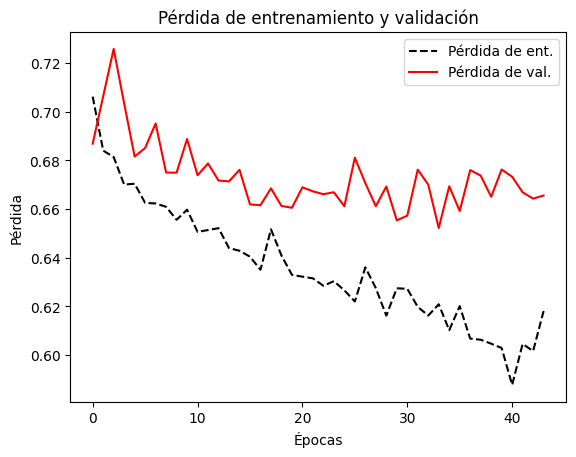

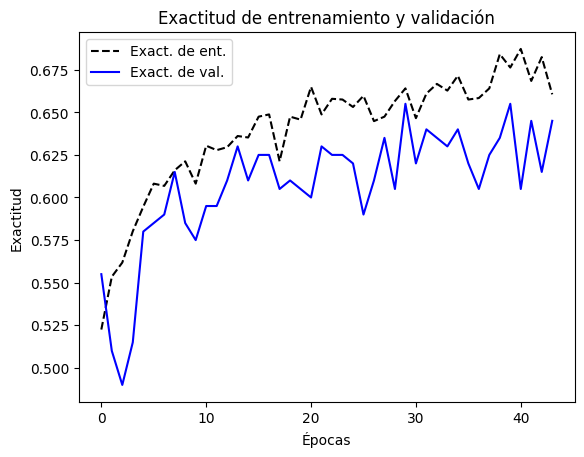

In [ ]:
# Llama a la función para graficar los resultados
plot_history(history)

# **Analizar los resultados**

Realizar evaluación sobre todo el conjunto de validación

In [ ]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists,
## so there is no need to make the model perfect.
modelo_personalizado.load_weights(weight_path)

#pred_Y = new_model.predict(valX, batch_size = 32, verbose = True)

#for i in range(math.floor(n_val_examples/batch_size)):
#    (xval, yval)val_gen.next()
#    predy = new_model.predict(valX, batch_size = 32, verbose = True)

pred_Y = modelo_personalizado.predict(valX, batch_size = 32, verbose = True)
#pred_Y.shape

#print(pred_Y)

7/7 [==============================] - 1s 131ms/step


# **Evaluar diversas métricas**

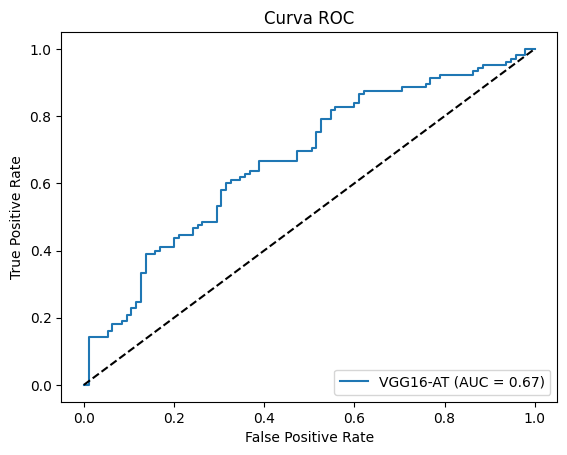

In [ ]:
# Importa las bibliotecas necesarias para graficar la curva ROC
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import auc

# Calcula la curva ROC
fpr, tpr, thresholds = roc_curve(valY, pred_Y, pos_label=1)

# Calcula el área bajo la curva ROC (AUC)
roc_auc = auc(fpr, tpr)

# Crea una visualización de la curva ROC
display = sk.metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=model_name + '-AT')
display.plot()

# Dibuja una línea diagonal (línea de referencia)
plt.plot([0, 1], [0, 1], 'k--')

# Establece el título del gráfico
plt.title('Curva ROC')

# Guarda el gráfico en formato EPS
plt.savefig(model_name + '_roc.eps', format='eps')

# Muestra el gráfico
plt.show()

In [ ]:
# Calcular la precisión, la recuperación (recall) y los umbrales para la curva de precisión-recuperación
precision, recall, thresholds = precision_recall_curve(valY, pred_Y)

# Calcular el área bajo la curva de precisión-recuperación (AUC) con recall como primer argumento
auc_keras = auc(recall, precision)

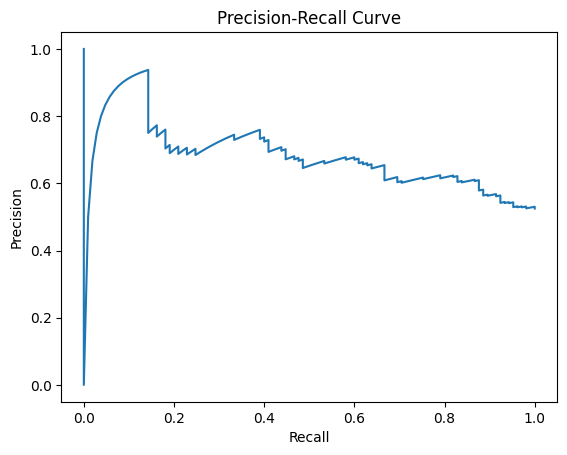

In [ ]:
plt.plot(recall, precision)
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.savefig(model_name + '_prc.eps', format='eps')
plt.show()

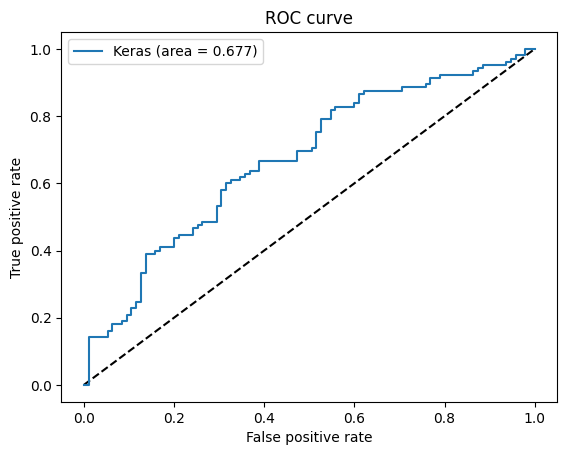

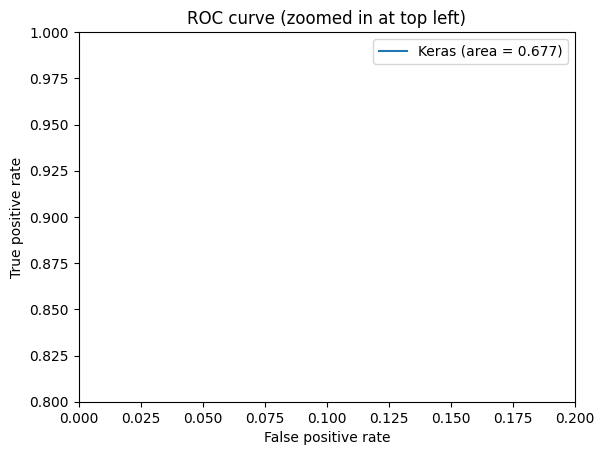

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

# **Optimización de métricas**

Una vez que sientas que has completado el entrenamiento, deberás decidir el umbral de clasificación adecuado que optimice el rendimiento de tu modelo para una métrica específica (por ejemplo, precisión, F1, precisión, etc., tú decides).

In [ ]:
def sensibility(tp, fn):
    return tp / (tp + fn)

def specificity(tn, fp):
    return tn / (tn + fp)

def getSensAndSpec(threshold, predictions):
    over_threshold = predictions >= threshold
    over_threshold = [[1] if result[0] else [0] for result in over_threshold]
    tn, fp, fn, tp = sk.metrics.confusion_matrix(valY, over_threshold).ravel()
    return [sensibility(tp, fn), specificity(tn, fp)]

def getF1(threshold, predictions):
    over_threshold = predictions >= threshold
    over_threshold = [[1] if result[0] else [0] for result in over_threshold]
    return f1_score(valY, over_threshold, average='macro')

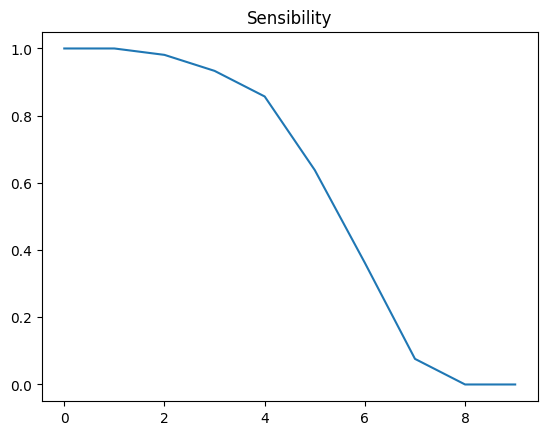

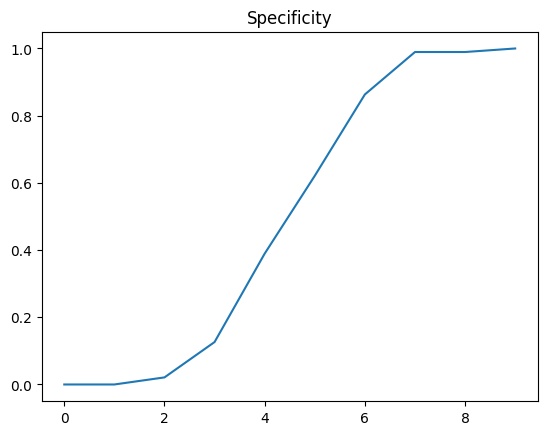

In [ ]:
# Optimization
Threshold = np.arange(0,1,0.1)

SensSpec = np.array([getSensAndSpec(thres, pred_Y) for thres in Threshold])

plt.plot(SensSpec[:,0])
plt.title('Sensibility')
plt.show()

plt.plot(SensSpec[:,1])
plt.title('Specificity')
plt.show()

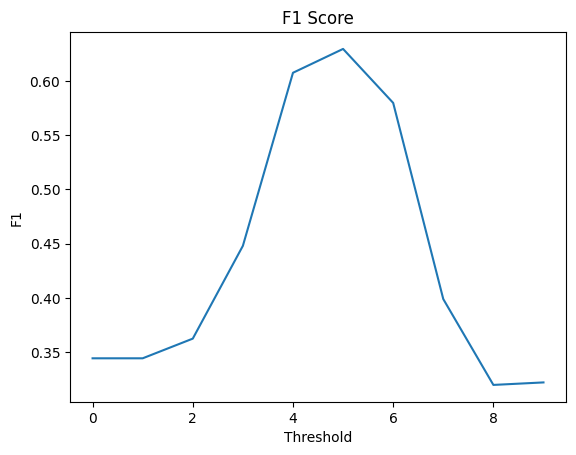

In [ ]:
# Optimization
F1s = np.array([getF1(thres, pred_Y) for thres in Threshold])
plot_f1s(F1s)

# **Performance of the selected threshold**

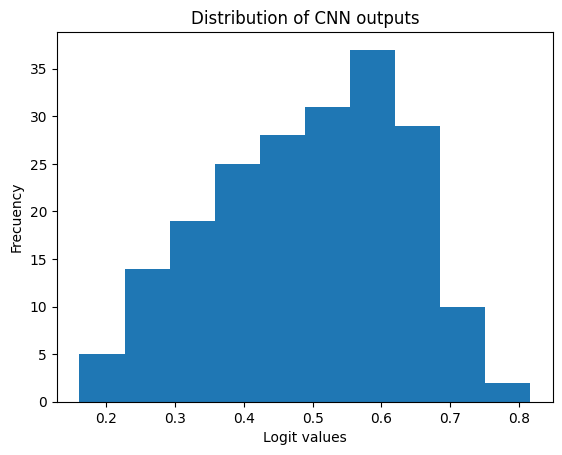

In [ ]:
# Plot output distributions

plt.hist(pred_Y, bins=10)
plt.title('Distribution of CNN outputs')
plt.ylabel('Frecuency')
plt.xlabel('Logit values')
plt.savefig(model_name + '_histogram.eps', format='eps')
plt.show()

In [ ]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# I am selecting sensibility as my target metric since I want to reduce false negatives.
# Even though the best F1 score is obtained when the threshold is equal to 0.5
# I selects threshold 0.4 because it shows a better sensibility
YOUR_THRESHOLD=0.5

over_threshold = pred_Y >= YOUR_THRESHOLD
#print(over_threshold[:10])
over_threshold = [[1] if result[0] else [0] for result in over_threshold]
#print(over_threshold[:10])

tn, fp, fn, tp = sk.metrics.confusion_matrix(valY, over_threshold).ravel()

print('Sensibility:', sensibility(tp, fn))
print('Specificity:', specificity(tn, fp))

Sensibility: 0.638095238095238
Specificity: 0.6210526315789474


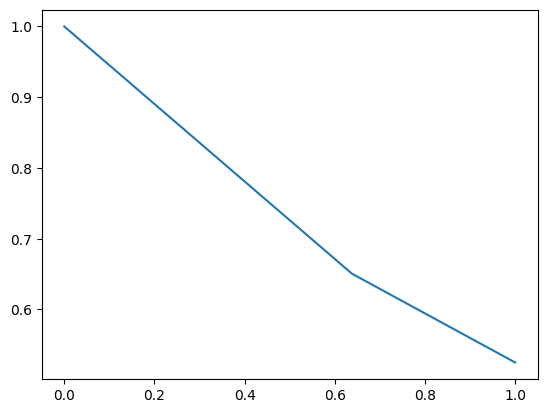

In [ ]:
precision, recall, thresholds = precision_recall_curve(valY, over_threshold)
plt.plot(recall, precision)
plt.show()

In [ ]:
f1_score(valY, over_threshold, average='macro')

0.6294070512820513

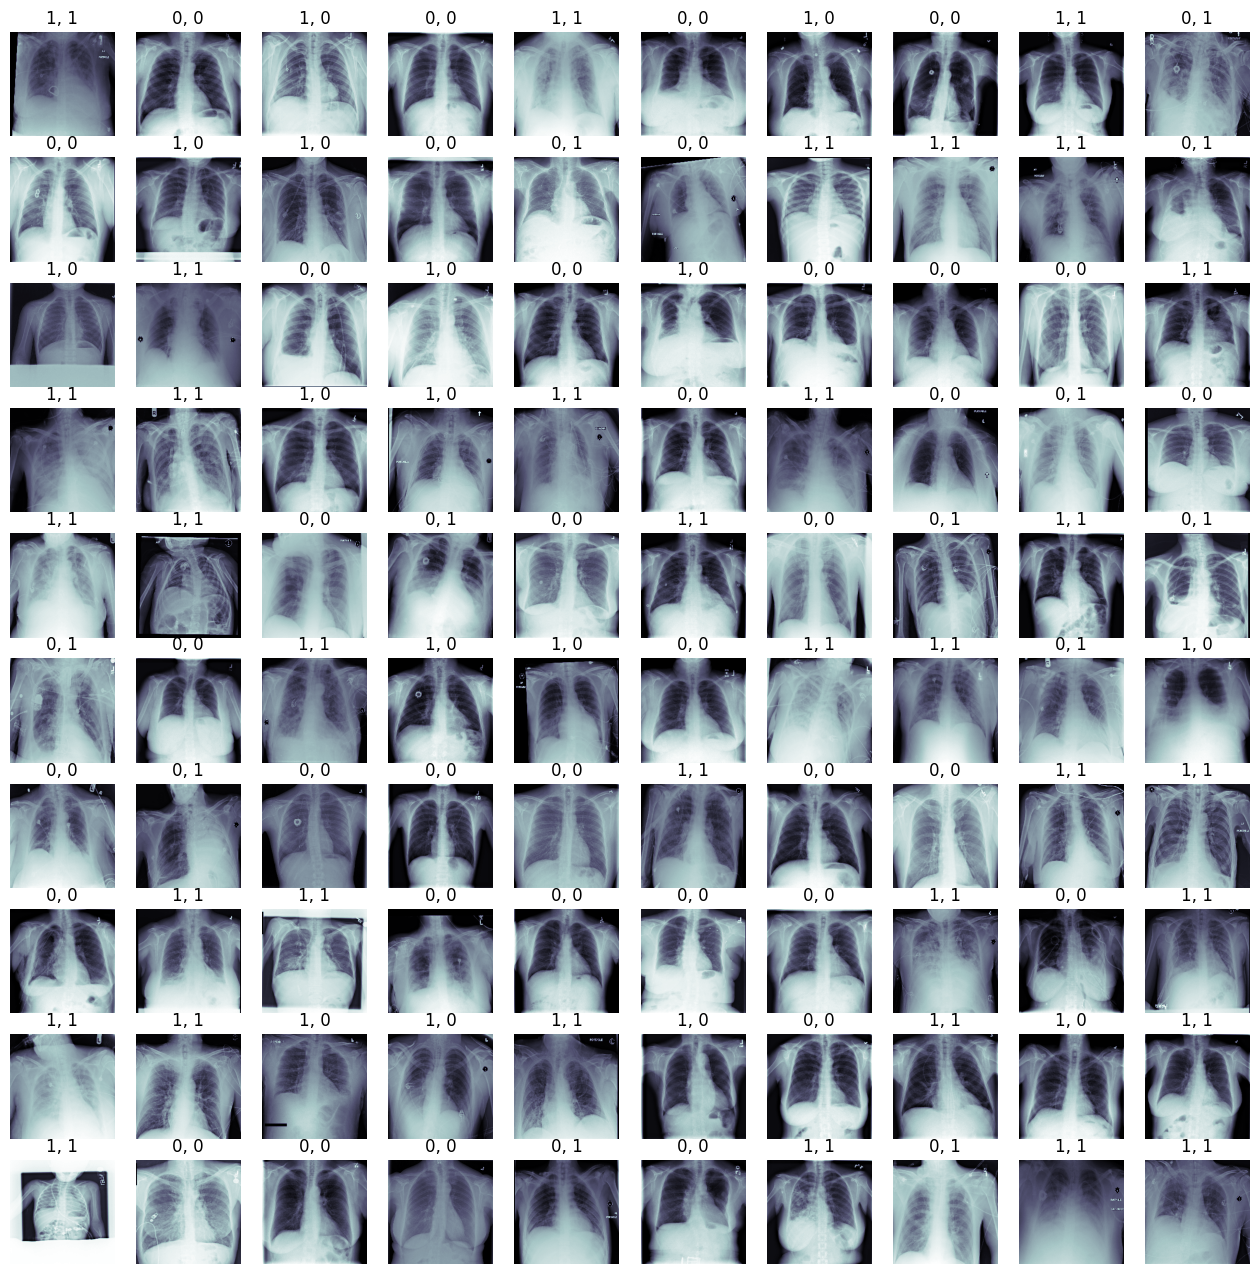

In [ ]:
## Let's look at some examples of true vs. predicted with our best model:

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    #valY
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1.:
        if pred_Y[i] > YOUR_THRESHOLD:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > YOUR_THRESHOLD:
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [ ]:
# Guarda la arquitectura del modelo en un archivo JSON
model_json = modelo_personalizado.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)